# NAMAC: MTA-TQN policy evaluation

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def lineplotMultiCI(CI_df,  modelNames, x_label, y_label, title, shade):
    
    fig, ax = plt.subplots(figsize=figsize)

    for i in range(len(modelNames)):
        ax.plot(CI_df.loc[:MAX_PLOT, timefeat], CI_df.loc[:MAX_PLOT, modelNames[i]], lw = lineW[i],\
                color = colors[i], alpha = 0.9, linestyle=line_style[i], \
                marker=markers[i],markersize=markersize, markevery=markevery, label = modelNames[i])
        
        if shade: # Shade: the confidence interval
            ax.fill_between(CI_df.loc[:MAX_PLOT,timefeat], CI_df.loc[:MAX_PLOT, modelNames[i]+'_lowCI'], \
                            CI_df.loc[:MAX_PLOT, modelNames[i]+'_upperCI'], color = colors[i], alpha = 0.1)

    #ax.set_title(title, fontsize=18)
    #ax.set_xlabel(x_label)
    #ax.set_ylabel(y_label)

    x = CI_df.loc[:MAX_PLOT, timefeat].values
    print("max(x): ", max(x))
    plt.xticks(np.arange(min(x), max(x)+10, 500000))
    xlabels = ['{:.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000] #'{:,.0f}'
    ax.set_xticklabels(xlabels)
    plt.xlabel(x_label, fontsize=labelSize, fontweight='bold')
    plt.ylabel(y_label, fontsize=labelSize, fontweight='bold')
    
    if logScale:
        ax.set_yscale('log')       

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    if legendPos: #'upper center'
        ax.legend(loc=plotLoc, bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=False, ncol=3, fontsize=legendSize, frameon=False, borderpad=0.9, labelspacing=0.8)#prop={'size':12},
    elif legendYes:
        ax.legend(loc=plotLoc,fontsize=legendSize,frameon=False)
    plt.xticks(fontsize=tickSize)
    plt.yticks(fontsize=tickSize)
    plt.show()

    return plt


def showAll(df,title, methods, labels, filename, shade, legendPos, legendSize, ncol=2, dpi=100, 
            bbox_to_anchor = (0.5, -0.2), legendLoc = 0,
            ytickMin= 0, ytickMax = 70, MAX_ITERATION=500000, xtickPeriod=10000):
    lw = 2
    ms=8
    df = df[df.iteration<=MAX_ITERATION]
    ite = df.iteration        

    fig, ax = plt.subplots(figsize=(8,6))
    #ax.grid(True)    
    #methods = df.columns[1:]
    for i in range(len(methods)):
        ax.plot(ite, df[methods[i]], label=labels[i], marker=markers[i],markevery=1, markersize=7,
                linestyle=line_style[i], color=colors[i], lw=lw)
        if shade:
            ax.fill_between(df.loc[:, 'iteration'], df.loc[:, methods[i]+'_lCI'], \
                            df.loc[:, methods[i]+'_uCI'], color = colors[i], alpha = 0.1)


    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    if legendPos: 
        plotLoc = 'upper center'
        ax.legend(loc=plotLoc, bbox_to_anchor=bbox_to_anchor, fancybox=True, shadow=False, ncol=ncol, \
                  fontsize=legendSize, frameon=False, borderpad=0.5, labelspacing=0.5)#prop={'size':12}, bbox_to_anchor=(0.5, -0.15)
    else:
#         plotLoc = 'lower right'
#         ax.legend(loc=plotLoc,fontsize=legendSize,frameon=False)
        ax.legend(loc=legendLoc, fontsize=legendSize,frameon=False) #legendLoc = (1.01, 0.1)
#         plt.tight_layout()
        
    plt.xticks(np.arange(min(ite), max(ite)+10, xtickPeriod))
    if ytickMin > 0:
        plt.yticks(np.arange(ytickMin, ytickMax, 2))
    #print("max(x):", max(x))
    xlabels = ['{:.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000] #'{:,.0f}'
    ax.set_xticklabels(xlabels)
    ax.set_ylim(ytickMin, ytickMax)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Utility', fontsize=22) #, fontweight='bold'
    plt.xlabel('Training update', fontsize=22)
    plt.title(title, fontsize=22)
    if filename != '':
        plt.savefig('eval/fig/'+filename+'.png', bbox_inches='tight', format='png', dpi=dpi)
        

def loadResult(epath, period=2000, sampleSize=10, MAX_ITERATION = 50000):
    mnames = os.listdir(epath)
    #mnames = [m for m in mnames if '1_8' not in m ]
    #mnames = [m for m in mnames if '1_1' not in m ]    
    evalList, trList = [], []
    print("Max iteration: ", MAX_ITERATION)
    for i in range(len(mnames)):
        a, tr = getEvalRes(epath, mnames[i], sampleSize, period, MAX_ITERATION)
        evalList.append(a)
        trList.append(tr)

    res = a[['iteration']]

    for e in evalList:
        res = pd.concat([res, e[e.columns[-4:]]], axis=1)
    res = res.sort_values('iteration')
    res.reset_index(drop=True, inplace=True)  

    restr = trList[0][['iteration']]
    for e in trList:
        restr = pd.concat([restr, e[e.columns[-4:]]], axis=1)
    return res, restr, mnames


def getEvalRes(epath, method, sampleSize, period, MAX_ITERATION):
    df = pd.DataFrame(columns = ['iteration'])
    iterations = [i * period for i in range(1,int(MAX_ITERATION/period)+1)]
    df['iteration'] = iterations

    #fnames = os.listdir(epath+method)
    fnames = ['eval_fold{}.csv'.format(i) for i in range(sampleSize)]
    for i in range(len(fnames)):
        tmp = pd.read_csv(epath+'{}/'.format(method)+fnames[i])
        
        tmp = tmp.loc[tmp.iteration.isin(iterations), ['avgUtil']].rename(
            columns={'avgUtil':method+str(i)}).reset_index(drop=True)
        
        df = pd.concat([df, tmp], axis=1)
        
    df[method] = df[df.columns[1:]].mean(axis=1).tolist()
    df[method+'_std'] = df[df.columns[1:]].std(axis=1).tolist()    # SD among policies
    
    # 95% Confidence interval 
    df[method+'_lCI'] = df[method] - 1.96* df[method+'_std']/math.sqrt(sampleSize)  
    df[method+'_uCI'] = df[method] + 1.96* df[method+'_std']/math.sqrt(sampleSize)
    df.loc[-1] = [0]*len(df.columns) 
    #df.reset_index(drop=True, inplace=True)
    trend = pd.DataFrame(columns = ['iteration', method, method+'_std'])
    trend.loc[0] = [0]*len(trend.columns) 
    iterations = [i * period for i in range(1,int(df.iteration.max()/period)+1)]

    for i in range(len(iterations)):
        selected = df.loc[(df.iteration>i*period)&(df.iteration<=(i+1)*period),df.columns[1:6]]
        trend.loc[len(trend)] = [(i+1)*period, selected.values.mean(), selected.values.std()]
        #print(trend)

    trend[method+'_lCI'] = trend[method] - 1.96* trend[method+'_std']/math.sqrt(len(selected)*sampleSize)  
    trend[method+'_uCI'] = trend[method] + 1.96* trend[method+'_std']/math.sqrt(len(selected)*sampleSize)

    
    return df, trend


def getCI(evalVal, sampleNum):
    CI_low = np.round(np.mean(evalVal)-1.96*np.std(evalVal)/np.sqrt(sampleNum), 1)
    CI_up = np.round(np.mean(evalVal)+1.96*np.std(evalVal)/np.sqrt(sampleNum), 1)
    return CI_low, CI_up 


def meanSD(res, title, models, threshold, MAX_ITERATION):
    rdf = pd.DataFrame(columns = ['model', 'avgUtil', 'SD', 'CI_low', 'CI_up'])
    con = res.loc[(res.iteration>=threshold)&(res.iteration<=MAX_ITERATION)]
    m = con[models].mean()
    s = con[models].std()
    #print( con.iteration.values)
    rdf['model'] = models
    rdf['avgUtil'] = np.round(m.tolist(),1)
    rdf['SD'] = np.round(s.tolist(),1)
    for i in range(len(models)):   
        mList =  con[models[i]].values.tolist()  
        #print(mList)
        CI_low, CI_up = getCI(mList, 10)
        rdf.loc[i, 'CI_low'] = CI_low
        rdf.loc[i, 'CI_up'] = CI_up
#     print("\n{}".format(title))
#     print("models\t\t\tmean\tSD")
#     for i in range(len(models)):
#         print("{}\t{:.1f}\t{:.1f}".format(models[i], m[i],s[i]))
    return rdf

def getEvalRes_qual(epath, methodList, iterations):
    target = ['avgUtil', 'maxTA21s1', 'meanPS2', 'meancv42C', 'hazardDur', 'maxHazardRate']

    edf = pd.DataFrame(columns = ['method']+['avgUtil_std']+ target)

    for method in methodList:
        #print(method)
        df = pd.DataFrame(columns = target)
        fnames = os.listdir(epath+method) 
#         fnames = [m for m in fnames if '1_8' not in m ]
        
        for i in range(len(fnames)):
            fpath = epath+'{}/'.format(method)+fnames[i]
            #print(fpath)
            tmp = pd.read_csv(fpath)
            val = tmp.loc[tmp.iteration.isin(iterations), target].values.mean(axis=0) #[0].tolist()
            df.loc[len(df)] = val

        util_std = np.round(df['avgUtil'].std(),1)
        edf.loc[len(edf)] = [method, util_std] + df[['avgUtil','maxTA21s1', 'meanPS2', 'meancv42C', 'hazardDur']].mean(axis=0).round(1).values.tolist() +df[['maxHazardRate']].mean(axis=0).round(2).values.tolist()
    return edf


def showBar_ml21(df, title, dpi=100, ylabel=False):
    fig, ax = plt.subplots(figsize=[8,5])
    width = 0.2
    #ax.grid(True)
    tqn   = df.loc[df.model.str.contains('TQN')].avgUtil.values.tolist()
    tdi  = df.loc[df.model.str.contains('TDiscount')].avgUtil.values.tolist()
    tst  = df.loc[df.model.str.contains('TState')].avgUtil.values.tolist()
    dqn  = df.loc[df.model.str.contains('DQN')].avgUtil.values.tolist()
    
    tqn_std = df.loc[df.model.str.contains('TQN')].SD.values
    tdi_std = df.loc[df.model.str.contains('TDiscount')].SD.values
    tst_std = df.loc[df.model.str.contains('TState')].SD.values
    dqn_std = df.loc[df.model.str.contains('DQN')].SD.values
    tqn_std = (tqn_std*1.96/np.sqrt(10)*2).tolist()
    dqn_std = (dqn_std*1.96/np.sqrt(10)*2).tolist()
    tdi_std = (tdi_std*1.96/np.sqrt(10)*2).tolist()
    tst_std = (tst_std*1.96/np.sqrt(10)*2).tolist()
    indices = np.arange(len(tqn))

    plt.bar([-0.2+i for i in indices], dqn, yerr=dqn_std, capsize=3,
            width=width, color='black', edgecolor='black', alpha=0.4, label='{}'.format('DQN'))
    plt.bar([i for i in indices], tst, yerr=tst_std, capsize=3,
            width=width, color='blue', edgecolor='black', alpha=0.6, label='{}'.format('TState'))
    plt.bar([0.2+i for i in indices], tdi, yerr=tdi_std, capsize=3,
            width=width, color='lightseagreen', edgecolor='black', alpha=0.8, label='{}'.format('TDiscount'))
    plt.bar([0.4+i for i in indices], tqn, width=width,  yerr=tqn_std, capsize=3,
            color='mediumvioletred', edgecolor='black',alpha=0.8,  label='{}'.format('TQN'))
    
    ax.set_ylim(25, 70)
    plt.xticks(indices, #+width/2., 
               ['TI [0.5, 2]', 'TI [0.5, 8]', 'TI [0.5, 16]'], rotation=0 , size=20)

    if ylabel:
        ax.annotate('baseline: 31.4', xy=(0, 30), color='black', xytext=(-0.2, 30.5), fontsize=18)        
        plt.ylabel('Avg. Util', fontsize=20)    
    else:
        ax.set_yticklabels(['']*6)
    plt.yticks(size=18)        
    plt.legend(loc=2, fontsize=18, frameon=False)
#     ax.vlines(ymin=0, ymax=0.97, x=0.5 , linewidth=2,linestyle='--', color='teal')
#     ax.vlines(ymin=0, ymax=0.97, x=2.5 , linewidth=2,linestyle='--', color='teal')
    #ax.hlines(y=0.1, xmin=0, xmax=7, colors='k', linestyles=':', label='')
    plt.axhline(y=30, color='black', linestyle=':', linewidth=1.5)

    if title !='':
        plt.savefig("./eval/fig/{}.png".format(title), bbox_inches='tight', format='png', dpi=dpi)

    plt.show()
    
def gather(res, miniter, maxiter):
    ndf = meanSD(res, '** non-TA', nonTA_models, miniter, maxiter)
    tdf = meanSD(res, '** irregular-TA', TA_models, miniter, maxiter)
    tdf8 = meanSD(res, '** irregular-TA8', TA8_models, miniter, maxiter)
    #tdf2= meanSD(res, '** irregular-TA2', TA2_models, miniter, maxiter)
    #adf = pd.concat([ndf, tdf, tdf8,tdf2], axis=0)
    adf = pd.concat([ndf, tdf, tdf8], axis=0)
    adf.reset_index(drop=True, inplace=True)
    return adf    


## Result 1:  Multi-Temopral Abstraction with Time-aware deep Q-Networks (MTA-TQN)

In [6]:
"""
Max training iteration = 50K 

Load the test results (*.csv) and analyze the evaluation metrics: 
- avgUtil: calcuated with online evaluation using the pretrained LSTM simulation model.
- 
"""
TA_models = ['DQN_PDD_lstm_ti1_4s3', 'TState_PDD_lstm_ti1_4s3',
 'TDiscount_PDD_lstm_ti1_4s3', 'TQN_PDD_lstm_ti1_4s3',]
nonTA_models = ['DQN_PDD_lstm_ti1_1s9', 'TState_PDD_lstm_ti1_1s9',
 'TDiscount_PDD_lstm_ti1_1s9', 'TQN_PDD_lstm_ti1_1s9']
modelNames = nonTA_models + TA_models

epath = 'eval/TA/071321_CV_t200_m250K/lr0.005_tau0.005/'  # All - len: 200, mem: 250K 

# Test: 10-fold Cross Validation with 2 times repititions, calculated at every 20K iterations up to 500K iterations
res, restr, mnames = loadResult(epath, period=20000, sampleSize=20, MAX_ITERATION = 500000)

# Final result table
iterations = [i * 10000 for i in range(50, 51)]
edf =  getEvalRes_qual(epath, modelNames, iterations)
edf.loc[len(edf)] = ['baseline',  13.9,31.6, 688.7,0, 0, 35.3, 0.70]
edf['Improv'] = np.round(edf.avgUtil / edf.loc[edf.method=='baseline', 'avgUtil'].values[0] *100, 1)
edf[['method', 'avgUtil', 'avgUtil_std',  'Improv','maxTA21s1', 'maxHazardRate', 'hazardDur']]

Max iteration:  500000


,method,avgUtil,avgUtil_std,Improv,maxTA21s1,maxHazardRate,hazardDur
0,DQN_PDD_lstm_ti1_1s9,37.6,13.2,119.0,680.8,0.40,17.1
1,TState_PDD_lstm_ti1_1s9,32.1,17.5,101.6,680.3,0.36,25.0
2,TDiscount_PDD_lstm_ti1_1s9,37.9,10.6,119.9,681.1,0.37,17.9
3,TQN_PDD_lstm_ti1_1s9,33.7,12.3,106.6,683.4,0.50,27.3
4,DQN_PDD_lstm_ti1_4s3,39.6,16.0,125.3,678.7,0.37,19.8
5,TState_PDD_lstm_ti1_4s3,38.5,17.3,121.8,677.8,0.31,19.7
6,TDiscount_PDD_lstm_ti1_4s3,50.5,13.2,159.8,676.4,0.30,15.2
7,TQN_PDD_lstm_ti1_4s3,61.9,9.5,195.9,670.3,0.10,2.3
8,baseline,31.6,13.9,100.0,688.7,0.70,35.3


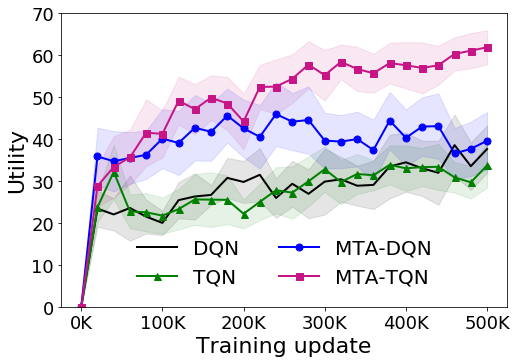

In [10]:
# Training curves
MAX_ITERATION = 500000
colors = ['black', 'green', 'blue', 'mediumvioletred']
markers = ['', '^', 'o','s']
line_style = ['-']*4
showAll(res[res.iteration<=MAX_ITERATION], '', 
        ['DQN_PDD_lstm_ti1_1s9', 'TQN_PDD_lstm_ti1_1s9','DQN_PDD_lstm_ti1_4s3', 'TQN_PDD_lstm_ti1_4s3'], 
        ['DQN', 'TQN', 'MTA-DQN', 'MTA-TQN'], 'nuclear_conv_all', 
        shade=True, legendPos = True, bbox_to_anchor = (0.5, 0.3),
        legendSize = 20, ytickMax=70,MAX_ITERATION=MAX_ITERATION, xtickPeriod=100000)

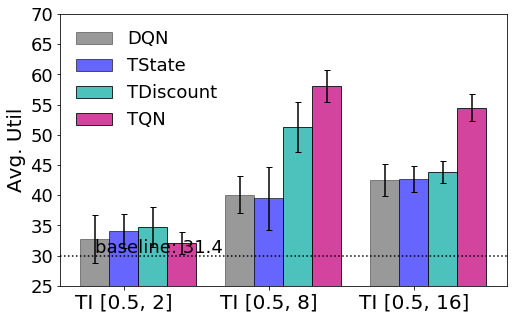

In [12]:
adf3050_2 = gather(res, 300000, 500000)
showBar_ml21(adf3050_2.loc[:11], title='nuclear_resbar', dpi=100, ylabel=True)